In [29]:
import pandas as pd

In [31]:
file_path = '/Users/valentinreateguirangel/Documents/MSc Machine Learning/Projects/Tesla_Stock_Prediction/Data/Tasla_Stock_Updated_V2.csv'
tesla_df = pd.read_csv(file_path)

In [33]:
tesla_df

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500
...,...,...,...,...,...,...,...
2269,2269,2024-01-09,238.110001,238.960007,232.039993,234.960007,96705700
2270,2270,2024-01-10,235.100006,235.500000,231.289993,233.940002,91628500
2271,2271,2024-01-11,230.570007,230.929993,225.369995,227.220001,105873600
2272,2272,2024-01-12,220.080002,225.339996,217.149994,218.889999,122889000


In [35]:
# dropping unnamed collumn 
tesla_df.drop(columns=['Unnamed: 0'], inplace=True)

In [37]:
tesla_df["Date"] = pd.to_datetime(tesla_df["Date"])

In [39]:
# Date to index
tesla_df.set_index('Date', inplace=True)

In [41]:
tesla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2274 entries, 2015-01-02 to 2024-01-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2274 non-null   float64
 1   High    2274 non-null   float64
 2   Low     2274 non-null   float64
 3   Close   2274 non-null   float64
 4   Volume  2274 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.6 KB


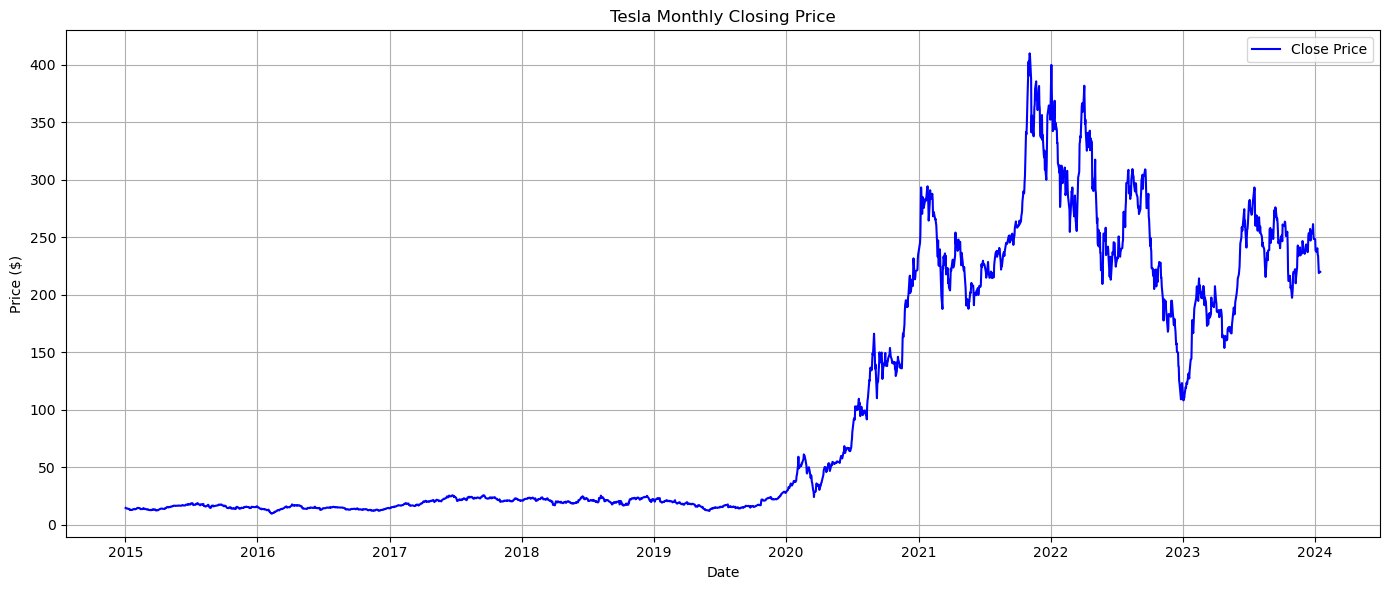

In [47]:
# Closing price plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(tesla_df['Close'], label='Close Price', color='blue')
plt.title('Tesla Monthly Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
# Resamling monthly (Mean)
monthly_df = tesla_df["Close"].resample("ME").mean()

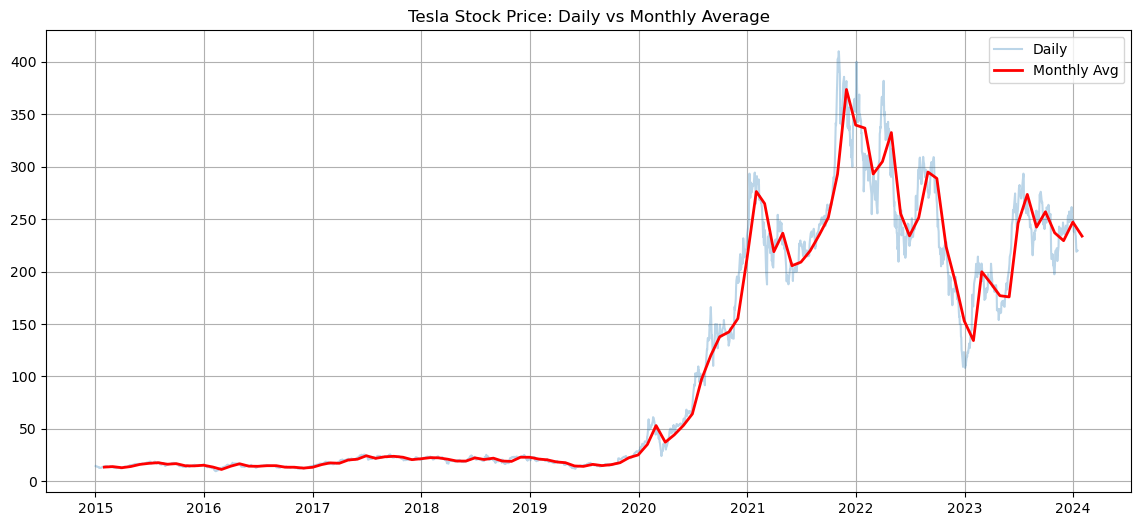

In [65]:
plt.figure(figsize=(14,6))
plt.plot(tesla_df['Close'], label='Daily', alpha=0.3)
plt.plot(monthly_df, label='Monthly Avg', color='red', linewidth=2)
plt.title('Tesla Stock Price: Daily vs Monthly Average')
plt.legend()
plt.grid(True)
plt.show()

## Trend a Seasonability analysis 

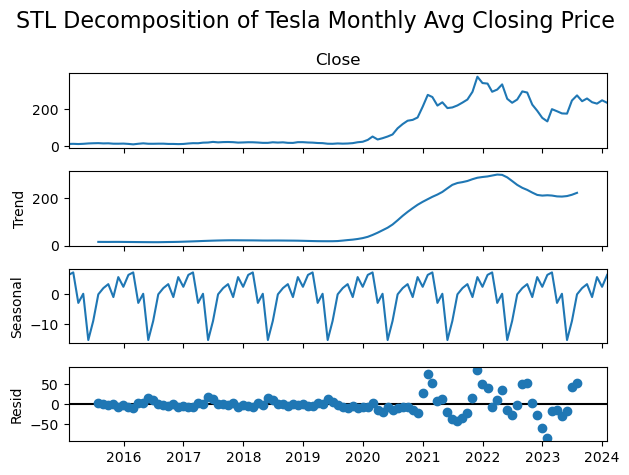

In [68]:
# STL decomposition , seasonal_decomposed method
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(monthly_df, model="additive", period= 12)

# Ploting
result.plot()
plt.suptitle("STL Decomposition of Tesla Monthly Avg Closing Price", fontsize = 16)
plt.tight_layout()
plt.show()

In [72]:
from prophet import Prophet

In [74]:
# Preparing data for prophet, it expects specific format ds and y.

prophet_df = monthly_df.reset_index()
prophet_df.columns = ["ds", "y"] # renaming to prophet
prophet_df.head()

,ds,y
0,2015-01-31,13.550367
1,2015-02-28,14.044877
2,2015-03-31,12.981212
3,2015-04-30,14.107429
4,2015-05-31,16.148033


In [76]:
# INIT model
model= Prophet()
model.fit(prophet_df)

12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
# Future Df
future = model.make_future_dataframe(periods=12, freq = "ME")
future.tail()

,ds
116,2024-09-30
117,2024-10-31
118,2024-11-30
119,2024-12-31
120,2025-01-31


In [82]:
# Forecasting future 
forecast = model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-09-30,303.498885,226.574172,376.482282
117,2024-10-31,299.706126,228.381954,376.953018
118,2024-11-30,306.949778,231.425932,376.882585
119,2024-12-31,308.209413,241.265454,386.069006
120,2025-01-31,317.477154,241.659555,394.612914


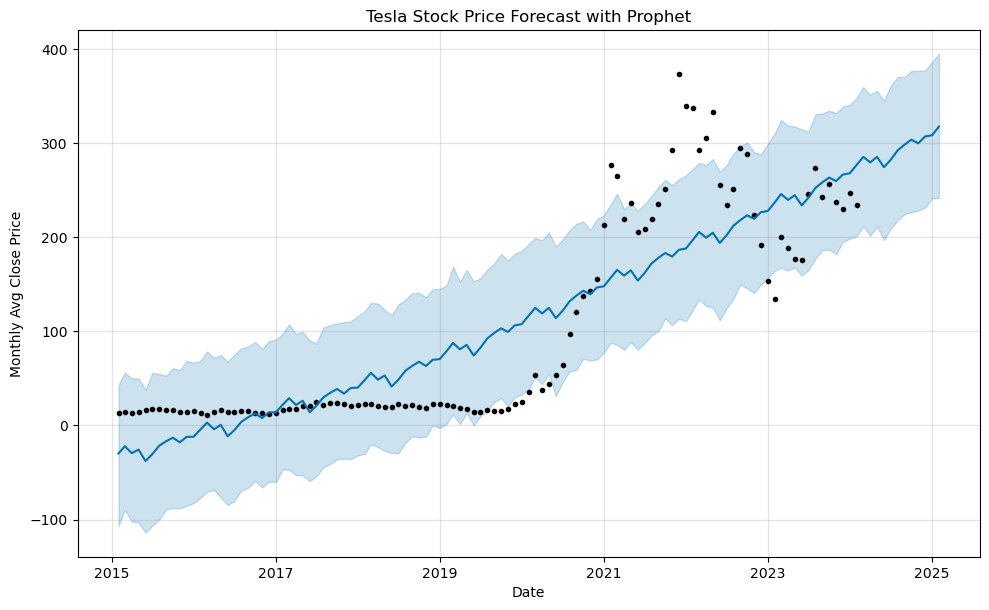

In [84]:
model.plot(forecast)
plt.title('Tesla Stock Price Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Monthly Avg Close Price')
plt.grid(True)
plt.show()

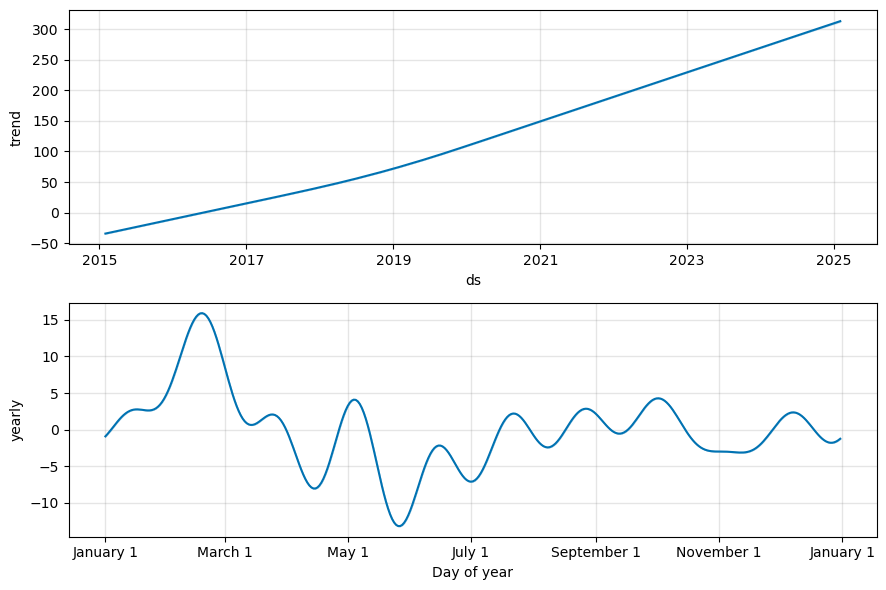

In [86]:
model.plot_components(forecast)
plt.show()

## ARIMA Model

In [97]:
# Augmented Dickey Fuller test (ADF),to check stationarity, which is needed for ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# drop missing values 
ts = monthly_df.dropna()

# ADF test
result = adfuller(ts)

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -1.126720880056257
p-value: 0.7042991644123456
Critical Value (1%): -3.4989097606014496
Critical Value (5%): -2.891516256916761
Critical Value (10%): -2.5827604414827157


In [99]:
# Smothing the series 
# First-order differencing (remove trend)
ts_diff = ts.diff().dropna()

# ADF test again on differenced data
result_diff = adfuller(ts_diff)

# Print results
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic (Differenced): -2.379997520805342
p-value: 0.14746172545115394
Critical Value (1%): -3.4989097606014496
Critical Value (5%): -2.891516256916761
Critical Value (10%): -2.5827604414827157


In [101]:
# Second differencing
ts_diff2 = ts.diff().diff().dropna()

# ADF test again
result_diff2 = adfuller(ts_diff2)

# Print results
print("ADF Statistic (Second Diff):", result_diff2[0])
print("p-value:", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic (Second Diff): -4.385064719703478
p-value: 0.00031542873433451884
Critical Value (1%): -3.502704609582561
Critical Value (5%): -2.8931578098779522
Critical Value (10%): -2.583636712914788


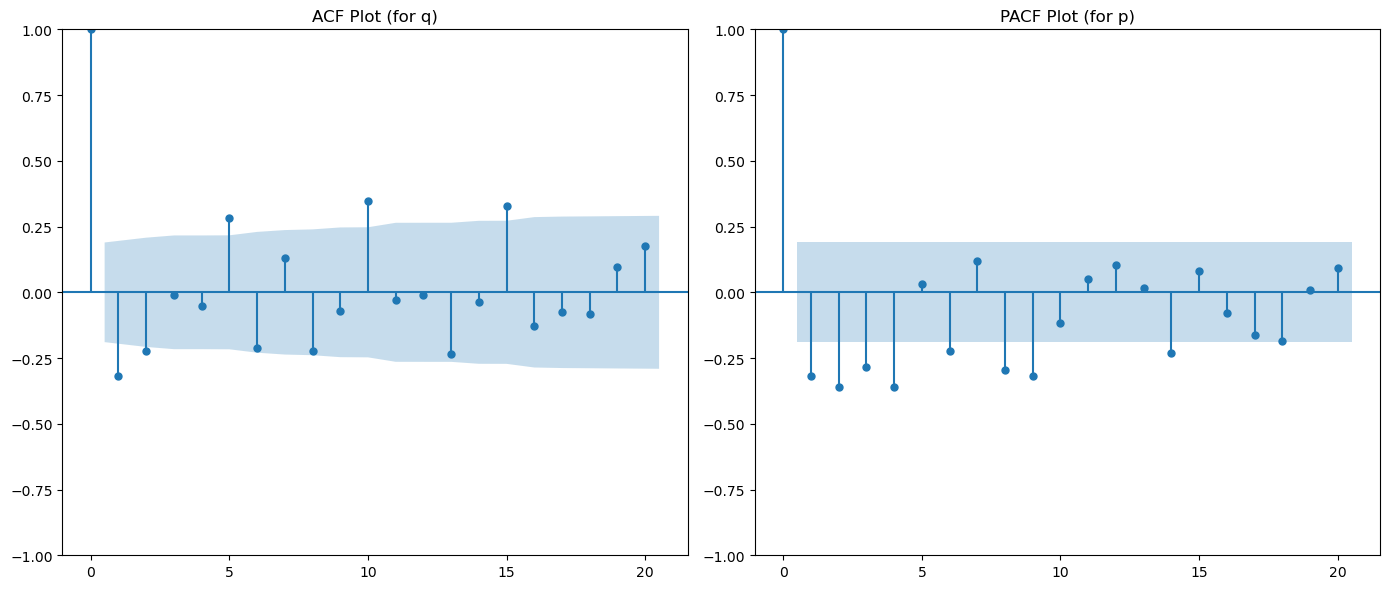

In [103]:
# Plots to pick p and q terms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(ts_diff2, ax=plt.gca(), lags=20)
plt.title('ACF Plot (for q)')

plt.subplot(1, 2, 2)
plot_pacf(ts_diff2, ax=plt.gca(), lags=20)
plt.title('PACF Plot (for p)')

plt.tight_layout()
plt.show()

In [105]:
# ARIMA chosing param (1,2,1)
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,2,1)
model = ARIMA(monthly_df, order=(1, 2, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  109
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -486.436
Date:                Mon, 07 Jul 2025   AIC                            978.873
Time:                        14:21:00   BIC                            986.891
Sample:                    01-31-2015   HQIC                           982.123
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1558      0.093      1.668      0.095      -0.027       0.339
ma.L1         -0.9984      0.328     -3.044      0.002      -1.641      -0.355
sigma2       500.2314    173.230      2.888      0.0

In [107]:
# Forecast
# Forecast 12 steps into the future
forecast = model_fit.forecast(steps=12)
forecast

2024-02-29    233.379569
2024-03-31    235.016532
2024-04-30    236.968777
2024-05-31    238.970150
2024-06-30    240.979177
2024-07-31    242.989397
2024-08-31    244.999804
2024-09-30    247.010239
2024-10-31    249.020678
2024-11-30    251.031118
2024-12-31    253.041559
2025-01-31    255.051999
Freq: ME, Name: predicted_mean, dtype: float64

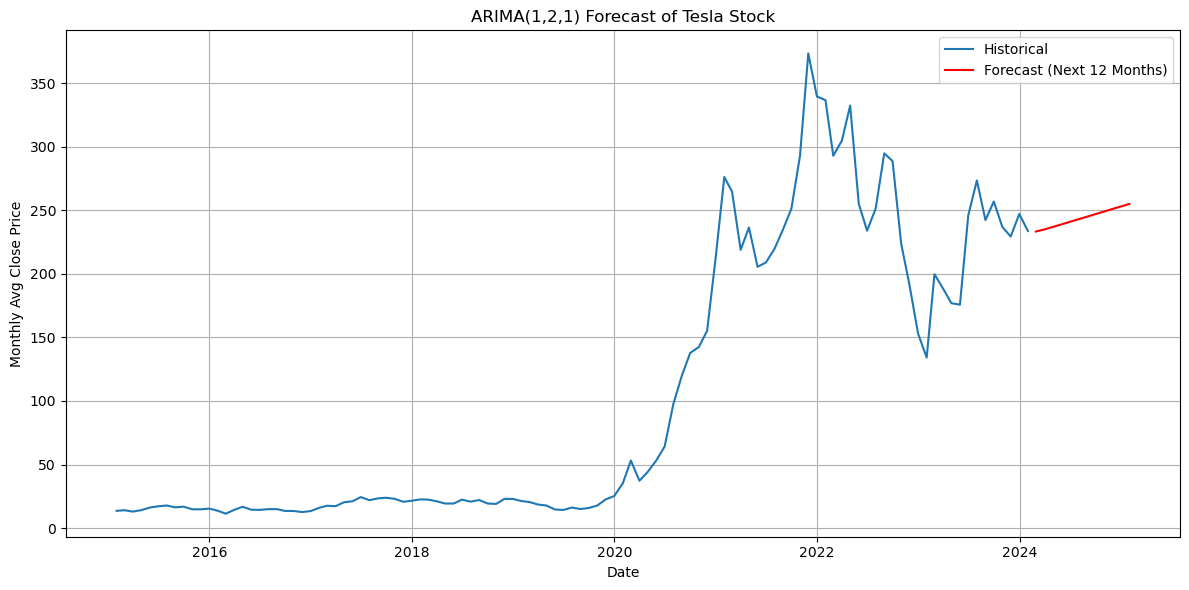

In [110]:
import matplotlib.pyplot as plt

# Plot historical + forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_df, label='Historical')
plt.plot(forecast.index, forecast, label='Forecast (Next 12 Months)', color='red')
plt.title('ARIMA(1,2,1) Forecast of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Monthly Avg Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost in Time Series

In [194]:
# Creating lags for XG
import pandas as pd

df = monthly_df.to_frame().copy()  

# Create lag feature, y(t-1), y(t-2), y(t-3).....
for lag in range(1, 12):
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Drop missing rows (the first few will be NaN due to shifting)
df.dropna(inplace=True)

df.head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Date,,,,,,,,,,,,
2015-12-31,15.344788,14.725467,14.798848,16.860412,16.303365,17.773303,17.133455,16.148033,14.107429,12.981212,14.044877,13.550367
2016-01-31,13.637474,15.344788,14.725467,14.798848,16.860412,16.303365,17.773303,17.133455,16.148033,14.107429,12.981212,14.044877
2016-02-29,11.311333,13.637474,15.344788,14.725467,14.798848,16.860412,16.303365,17.773303,17.133455,16.148033,14.107429,12.981212
2016-03-31,14.409818,11.311333,13.637474,15.344788,14.725467,14.798848,16.860412,16.303365,17.773303,17.133455,16.148033,14.107429
2016-04-30,16.730603,14.409818,11.311333,13.637474,15.344788,14.725467,14.798848,16.860412,16.303365,17.773303,17.133455,16.148033


In [196]:
# Spliting for evaluation
# Set forecast horizon
horizon = 12

# Split into train and test sets
train = df[:-horizon]
test = df[-horizon:]

# X = all lag features; y = target variable
X_train, y_train = train.drop(columns='Close'), train['Close']
X_test, y_test = test.drop(columns='Close'), test['Close']

In [198]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [200]:
y_pred = model.predict(X_test)

In [202]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 25.35600771495391
R²: 0.3314332256511038


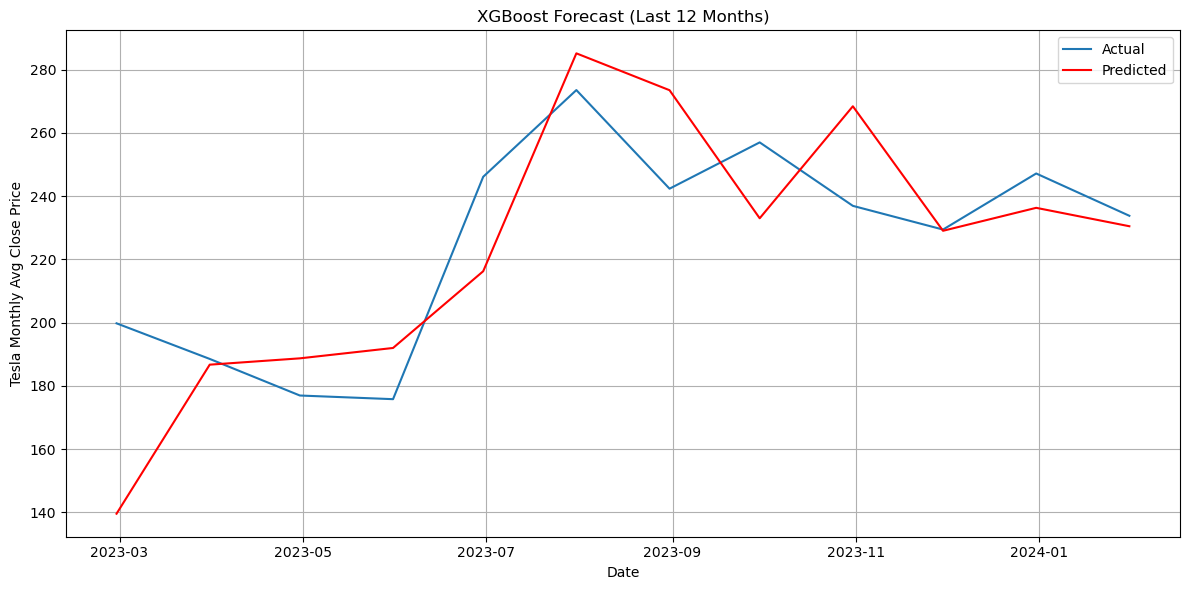

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title("XGBoost Forecast (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Tesla Monthly Avg Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()